## Summary
Using the following [Kaggle Dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval), explore several pre-processing (with and without stemming, with and without lemmatization, stopwords, etc) and information retrieval algorithms (TF-IDF or BM25). Use the evaluation metrics you learnt to compare your system against the expected results.

There are three files:
* CISI.ALL (corpus)
* CISI.QRY (queries)
* CISI.REL (relevance scores i.e labels)

# Step 1 - Load dataset

You will notice that the dataset is not in a CSV format, you'll have to figure out a way to parse and process it.

In [ ]:
def get_current_key(text, keys):
  for key in keys:
    if text.startswith(key[0]):
      return key[1]

  return None

#Note: We could also have used regex
def parse_documents(file_name, keys):
  with open(file_name) as f:
    lines = f.readlines()

  documents = []
  ignore = False
  current_obj = {}
  for line in lines:
    line = line.strip()
    new_key = get_current_key(line, keys)

    if new_key == 'Id':
      current_obj = {}
      current_obj["Id"] = line.split(' ')[-1]
      documents.append(current_obj)
      ignore = False
      continue

    if new_key:
      current_key =  new_key
      ignore = False
      continue

    if ignore:
      continue

    if line.startswith('.'):
      ignore = True
      continue

    if current_key in current_obj.keys():
      current_obj[current_key] += line
    else:
      current_obj[current_key] = line

  return documents

In [ ]:
keys = [(".I", "Id"), (".T", "Title"), (".A", "Author"), ('.W', "Abstract"),(".X", "CrossRefs")]

documents = parse_documents('CISI.ALL', keys)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(documents).set_index("Id")[["Title","Author","Abstract"]]
df

,Title,Author,Abstract
Id,,,
1,18 Editions of the Dewey Decimal Classifications,"Comaromi, J.P.",The present study is a history of the DEWEY De...
2,Use Made of Technical Libraries,"Slater, M.",This report is an analysis of 6300 acts of use...
3,Two Kinds of PowerAn Essay on Bibliographic Co...,"Wilson, P.",The relationships between the organization and...
4,Systems Analysis of a University Library;final...,"Buckland, M.K.",The establishment of nine new universities in ...
5,A Library Management Game:a report on a resear...,"Brophy, P.",Although the use of games in professional educ...
...,...,...,...
1456,World Dynamics,"Forrester, J.W.",Over the last several decades interest in econ...
1457,World Trends in Library Education,"Bramley, G.",One of the most significant aspects of the evo...
1458,Legal Restrictions on Exploitation of the Pate...,"Baxter, W.A.",The patent laws confer on a patentee power to ...


In [ ]:
corpus = df.apply(lambda x: ' '.join(x), axis = 1).values

In [ ]:
keys = [(".I", "Id"), (".W", "Query")]

documents = parse_documents('CISI.QRY', keys)
queries = pd.DataFrame(documents).set_index("Id")[["Query"]]
queries

,Query
Id,
1,What problems and concerns are there in making...
2,"How can actually pertinent data, as opposed to..."
3,What is information science? Give definitions...
4,Image recognition and any other methods of aut...
5,What special training will ordinary researcher...
...,...
108,A technique of online instruction and assistan...
109,It is shown that the mapping of a particular a...
110,"The ""Office of the Future,"" ""Office Technology..."


In [ ]:
import re
def parse_ground_truth(file_name):
  with open(file_name, 'r') as f:
    lines = f.readlines()

  lines = [line.strip() for line in lines]
  lines = [line.replace('\t', ' ') for line in lines]
  lines = [re.sub(r'\s+', ' ', line) for line in lines]

  split = [{"QueryId":i.split(' ')[0], "DocId":i.split(' ')[1]} for i in lines]

  queryIds = set([i["QueryId"] for i in split])

  ground_truth = {id: [] for id in queryIds}
  for item in split:
    queryId = str(item["QueryId"])
    ground_truth[queryId] = ground_truth[queryId] + [item["DocId"]]

  return ground_truth

ground_truth = parse_ground_truth('CISI.REL')

In [ ]:
#ground_truth

# Step 2 - Define a baseline for your information retrieval system

i.e Do something as simple as possible, and evaluate it with Precision@K, Recall@K and F1-Score@K.

Note: Why not also use NDCG ? Do we have enough information for that ?

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

In [ ]:
def get_results(query, query_vector, word_vectors):
    cosine_sim = cosine_similarity(query_vector, word_vectors)
    result = pd.DataFrame(data = {"documents": corpus, 'similarity': cosine_sim[0]}).sort_values("similarity", ascending=False)
    return result

In [ ]:
def get_rels(query, k = None):
  query = query.Query
  query_vector = tfidf_vectorizer.transform([query])
  result = get_results(query, query_vector, tfidf_matrix)
  if k:
    result = result[:k]
  return result.apply(lambda x:x.name + 1, axis = 1).values

In [ ]:
qrels = queries.apply(lambda x: get_rels(x),axis = 1 ).to_frame()
#qrels are judgments made by humans as to whether a document is relevant to an information need

In [ ]:
def get_true_positives(predicted_list, real_list):
  true_positives = []
  for predicted in predicted_list:
    true_positives.append(str(predicted) in real_list)
  return true_positives

In [ ]:
results_t = qrels.apply(lambda x: get_true_positives(x[0] ,ground_truth[str(x.name)]) if str(x.name) in ground_truth.keys() else None, axis=1).dropna().to_frame()

In [ ]:
def precision_at_k(results, k = 10, average = True):
  evaluation = results.apply(lambda x: sum(x[0][:k])/k, axis = 1)

  if average:
    return evaluation.mean()

  return evaluation

precision_at_k(results_t, 10)

0.27368421052631586

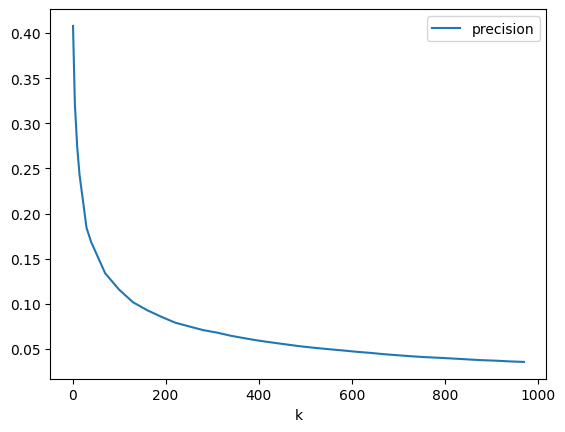

In [ ]:
def plot_precision_at_k(results):
  ks = [1,5,10,15,30] + [i for i in range(40, 1000, 30)]

  precision_results = []
  for k in ks:
    precision_results = precision_results + [precision_at_k(results, k)]

  pd.DataFrame(data={"k":ks, "precision":precision_results}).plot(x='k', y='precision')

plot_precision_at_k(results_t)

# Step 3 - Explore and try to improve your system.

Tips:
* Stemming
* Lemmatization
* Different tokenization algorithms
* Remove possibly irrelevant words (subjective)
* Be creative 💪